In [24]:
## quick plotting function with adjustable vertical line to check readout at user-specified energies

import os
import numpy as np
import matplotlib.pyplot as plt
import struct
from scipy.signal import find_peaks
from ipywidgets import Text, fixed, VBox, Output

def view_chn_spectrum(filepath, a=0.2878, b=-9.14, prominence=500, width=600, show_line=True):
    def read_ortec_chn(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
        num_channels = struct.unpack('<H', data[20:22])[0]
        spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
        full_counts = np.array(spectrum_data)

        # Use only the half that is non-zero
        if np.all(full_counts[::2] == 0):
            counts = full_counts[1::2]  # use odd bins
            offset = 1
        elif np.all(full_counts[1::2] == 0):
            counts = full_counts[::2]  # use even bins
            offset = 0
        else:
            counts = full_counts
            offset = 0

        return counts, offset

    def channel_to_energy(channels, a, b):
        return a * channels + b

    def plot_spectrum(counts, a, b, x_value, show_line):
        channels = np.arange(len(counts)) * 2 + offset
        energy = channel_to_energy(channels, a, b)

        # Snap to nearest bin
        index = np.argmin(np.abs(energy - x_value))
        snapped_energy = energy[index]
        value_at_x = counts[index]

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(energy, counts, label='Counts')
        ax.set_xlim(left=0, right=2000)
        ax.set_yscale('log')

        # Conditionally show red line and text
        if show_line:
            ax.axvline(x=snapped_energy, color='r', linestyle='--')
            ax.scatter(snapped_energy, value_at_x, color='r')
            ax.text(snapped_energy + 0.2, value_at_x + 0.1,
                    f'Value: {value_at_x:.2f}\nEnergy: {snapped_energy:.2f} keV',
                    color='r', fontsize=9)

        # Add labels, title, etc.
        ax.set_title(f'Spectrum from {filepath}')
        ax.set_xlabel('Energy (keV)')
        ax.set_ylabel('Counts')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

    # Load data
    counts, offset = read_ortec_chn(filepath)
    channels = np.arange(len(counts))
    energy = channel_to_energy(channels, a, b)
    energy_min, energy_max = energy[0], energy[-1]

    # Text box widget
    energy_text = Text(
        value=str(0),
        description='Energy:',
        continuous_update=False
    )

    out = Output()

    def update_plot(change):
        with out:
            out.clear_output()
            try:
                val = float(change['new'])
                if energy_min <= val <= energy_max:
                    plot_spectrum(counts, a, b, val, show_line)
            except ValueError:
                pass  # Invalid input — ignore

    energy_text.observe(update_plot, names='value')

    # Show initial plot
    with out:
        plot_spectrum(counts, a, b, float(energy_text.value), show_line)

    return VBox([energy_text, out])

In [14]:
folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25"
files = [os.path.join(folder, file_path) for file_path in os.listdir(folder)]

for f in files:
    display(view_chn_spectrum(f, a=0.2878, b=-9.14, show_line=True));

In [25]:
## function to read out first 100 bins of .chn file

import struct
import numpy as np

def read_ortec_chn(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
    num_channels = struct.unpack('<H', data[20:22])[0]
    spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
    return np.array(spectrum_data)

def channel_to_energy(channels, a, b):
    return a * channels + b

def print_first_100_bins(filepath, a=0.172, b=-5.92):
    counts = read_ortec_chn(filepath)
    channels = np.arange(len(counts))
    energy = channel_to_energy(channels, a, b)

    print(f"{'Channel':>7} {'Energy (keV)':>15} {'Counts':>10}")
    print('-' * 35)
    for ch in range(min(100, len(counts))):
        print(f"{ch:7d} {energy[ch]:15.3f} {counts[ch]:10d}")

# Example usage:
# Replace with the path to your .CHN file
filepath = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\cs-137 (pb backing).Chn"
print_first_100_bins(filepath)

Channel    Energy (keV)     Counts
-----------------------------------
      0          -5.920          0
      1          -5.748          0
      2          -5.576          0
      3          -5.404          0
      4          -5.232          0
      5          -5.060          0
      6          -4.888          0
      7          -4.716          0
      8          -4.544          0
      9          -4.372          0
     10          -4.200          0
     11          -4.028          0
     12          -3.856          0
     13          -3.684          0
     14          -3.512          0
     15          -3.340          0
     16          -3.168          0
     17          -2.996          0
     18          -2.824          0
     19          -2.652          0
     20          -2.480          0
     21          -2.308          0
     22          -2.136          0
     23          -1.964          0
     24          -1.792          0
     25          -1.620          0
     26          -1

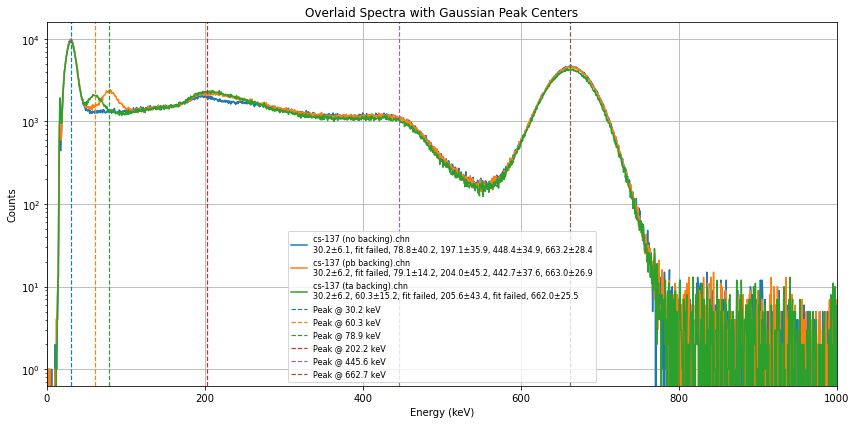

In [23]:
## function to plot spectra and fit gaussians

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import struct
import matplotlib.cm as cm
from collections import defaultdict

# === Utility Functions ===

def read_ortec_chn(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
    num_channels = struct.unpack('<H', data[20:22])[0]
    spectrum_data = struct.unpack('<' + 'H' * num_channels, data[32:32 + 2 * num_channels])
    full_counts = np.array(spectrum_data)

    if np.all(full_counts[::2] == 0):
        counts = full_counts[1::2]
        offset = 1
    elif np.all(full_counts[1::2] == 0):
        counts = full_counts[::2]
        offset = 0
    else:
        counts = full_counts
        offset = 0

    return counts, offset

def get_runtime_seconds(filepath):
    with open(filepath, 'rb') as f:
        f.seek(14)
        live_time = struct.unpack('<f', f.read(4))[0]
    return live_time

def channel_to_energy(channels, a=0.2878, b=-9.14):
    return a * channels + b

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def cluster_peaks_with_singletons(peaks_by_sample, width_factor=1.5):
    """Cluster peaks across all samples, preserving singleton sample peaks."""
    all_peaks = [(center, sigma, sample) for sample, peaks in peaks_by_sample.items() for center, sigma in peaks]
    all_peaks.sort(key=lambda x: x[0])  # sort by center

    clusters = []
    used = [False] * len(all_peaks)

    for i, (center_i, sigma_i, sample_i) in enumerate(all_peaks):
        if used[i]:
            continue

        cluster = [(center_i, sigma_i, sample_i)]
        used[i] = True

        for j in range(i + 1, len(all_peaks)):
            center_j, sigma_j, sample_j = all_peaks[j]
            avg_sigma = (sigma_i + sigma_j) / 2
            if abs(center_j - center_i) <= width_factor * avg_sigma:
                cluster.append((center_j, sigma_j, sample_j))
                used[j] = True

        # Keep cluster average if more than one sample OR singleton
        sample_set = {s for _, _, s in cluster}
        if len(sample_set) > 1:
            avg_center = np.mean([c for c, _, _ in cluster])
            clusters.append(avg_center)
        else:
            clusters.extend([c for c, _, _ in cluster])  # Keep singleton directly

    return sorted(clusters)

# === Core Logic ===

def process_and_plot_overlay(data_files, background_file, peak_guesses_kev, a=0.2878, b=-9.14, window_kev=10):
    bkg_counts, _ = read_ortec_chn(background_file)
    bkg_runtime = get_runtime_seconds(background_file)

    plt.figure(figsize=(12, 6))
    plt.xlim(0, 1000)

    peak_data_by_sample = defaultdict(list)

    for data_file in data_files:
        sample_name = os.path.basename(data_file)
        data_counts, offset = read_ortec_chn(data_file)
        data_runtime = get_runtime_seconds(data_file)

        scale = data_runtime / bkg_runtime
        net_counts = data_counts - bkg_counts * scale
        net_counts = np.clip(net_counts, 0, None)

        channels = np.arange(len(net_counts)) * 2 + offset
        energy = channel_to_energy(channels, a, b)

        peak_results = []

        for peak_guess_kev in peak_guesses_kev:
            idx_min = np.argmin(np.abs(energy - (peak_guess_kev - window_kev)))
            idx_max = np.argmin(np.abs(energy - (peak_guess_kev + window_kev)))
            x_fit = energy[idx_min:idx_max]
            y_fit = net_counts[idx_min:idx_max]

            a0 = np.max(y_fit)
            x0 = x_fit[np.argmax(y_fit)]
            sigma0 = 2
            p0 = [a0, x0, sigma0]

            try:
                popt, _ = curve_fit(gaussian, x_fit, y_fit, p0=p0)
                center_energy = popt[1]
                sigma_energy = popt[2]
                peak_data_by_sample[sample_name].append((center_energy, sigma_energy))
                peak_results.append(f"{center_energy:.1f}±{sigma_energy:.1f}")
            except RuntimeError:
                peak_results.append("fit failed")

        label = f"{sample_name}\n" + ", ".join(peak_results)
        plt.plot(energy, net_counts, label=label)

    # Cluster peaks across samples, preserving single-sample peaks
    final_peak_lines = cluster_peaks_with_singletons(peak_data_by_sample, width_factor=0.5)

    # Plot peak lines
    colors = cm.tab10.colors
    for i, center in enumerate(final_peak_lines):
        color = colors[i % len(colors)]
        plt.axvline(center, color=color, linestyle='--', linewidth=1.2, label=f'Peak @ {center:.1f} keV')

    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys(), fontsize=8)

    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.yscale('log')
    plt.title('Overlaid Spectra with Gaussian Peak Centers')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Usage ===

folder = "C:\\Users\\livia\\Downloads\\College\\PHYS 4410\\N-0\\Data\\4-30-25\\"

data_files = [
    folder + "cs-137 (no backing).chn",
    folder + "cs-137 (pb backing).chn",
    folder + "cs-137 (ta backing).chn"
]

background_file = folder + "bkg.chn"
peak_guesses = [30, 60, 80, 200, 480, 662]  # keV

process_and_plot_overlay(data_files, background_file, peak_guesses)